In [23]:
import torch 
from torch.utils.data import DataLoader
from tqdm import tqdm
import os 
from fungi_network import FungiDataset, get_transforms, ensure_folder
from vit_base import MultiModalViTFusion
from attributeEmbedder_v2 import AttributeEmbedderV2
import pandas as pd 
import numpy as np
import csv 

In [9]:
image_path = 'C:/Users/bmsha/sc2025/FungiImages'
# Path to metadata file
data_file = str('C:/Users/bmsha/sc2025/metadata_1/metadata_fused.csv')

# Session name: Change session name for every experiment! 
# Session name will be saved as the first line of the prediction file
session = "vit-base-patch16-224"
# Folder for results of this experiment based on session name:
checkpoint_dir = os.path.join(f"C:/Users/bmsha/sc2025/checkpoints/{session}/")

In [16]:
CameraModelSTxt = 'C:/Users/bmsha/sc2025/metadata_1/camera_models.txt'
CameraMakerTxt = 'C:/Users/bmsha/sc2025/metadata_1/camera_makers.txt'

ensure_folder(checkpoint_dir)

# Model and Test Setup
best_trained_model = os.path.join(checkpoint_dir, "best_accuracy.pth")
output_csv_path = os.path.join(checkpoint_dir, "test_predictions.csv")

df = pd.read_csv(data_file)
test_df = df[df['filename_index'].str.startswith('fungi_train')]
test_dataset = FungiDataset(test_df, image_path, CameraModelSTxt, CameraMakerTxt, transform=get_transforms(data='valid'), multi_modal=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 183 
csv_embedder = AttributeEmbedderV2(
    num_habitats=test_dataset.tokenizer.num_habitats,
    num_substrates=test_dataset.tokenizer.num_substrates,
    num_camera_models=test_dataset.tokenizer.num_camera_models,
    num_camera_makers=test_dataset.tokenizer.num_camera_makers,
    num_embedding_dims=64,  # E
    fourier_features=8,     # F
    geo_scale=10.0          # scale for Fourier features
)
model = MultiModalViTFusion(
    num_classes=num_classes,
    attr_embedder=csv_embedder,
    attr_token_dim=64,
    attr_num_tokens=6,
    vit_name="google/vit-base-patch16-224",
    cross_attn_heads=8,
    cross_attn_layers=4,
    mlp_ratio=4.0,
    dropout=0.1,
    pool="cls+vitcls",
    use_attr_self_attn=True,
).to(device)

model.load_state_dict(torch.load(best_trained_model))
model.to(device)

# Collect Predictions
results = []
model.eval()

progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))
progress_bar.set_description(desc=f"Final Evaluation on Test Set - {session}")
    
with torch.no_grad():
    for step, batch in progress_bar:
        # Unpack batch
        images, labels, filenames, habitat, substrate, month, day, camera_model, camera_maker, latitude, longitude = batch
        images = images.to(device)
        habitat = habitat.to(device).long(); substrate = substrate.to(device).long()
        month = month.to(device).long(); day = day.to(device).long()
        camera_model = camera_model.to(device).long(); camera_maker = camera_maker.to(device).long()
        latitude = latitude.to(device).float(); longitude = longitude.to(device).float()

        outputs = model(images, habitat, substrate, month, day, camera_model, camera_maker, latitude, longitude)
        predictions = outputs.argmax(1).cpu().numpy()
        #calculate the accruacy for each class
        for filename, label, pred in zip(filenames, labels, predictions):
            label = label.item() if isinstance(label, torch.Tensor) else label
            results.append((filename, label, pred))
        

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Final Evaluation on Test Set - vit-base-patch16-224: 100%|██████████| 809/809 [04:35<00:00,  2.93it/s]


Text(0.5, 0, 'Class')

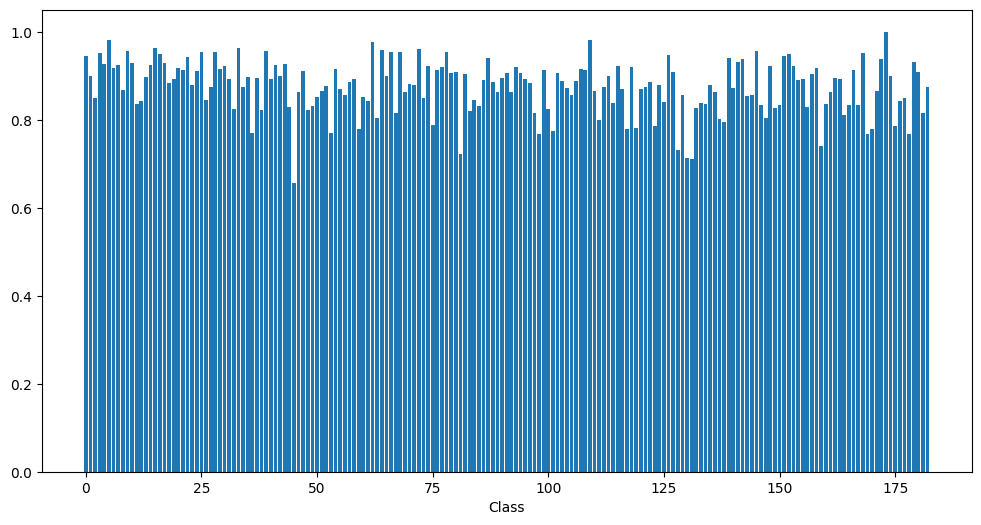

In [18]:
# calculate accuracy for each class in results
results_df = pd.DataFrame(results, columns=['filename', 'label', 'prediction'])
results_df['correct'] = results_df['label'] == results_df['prediction']
accuracy_per_class = results_df.groupby('label')['correct'].mean().reset_index()
accuracy_per_class.columns = ['class', 'accuracy']
#plot the accuracy per class as a bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(accuracy_per_class['class'], accuracy_per_class['accuracy'])
plt.xlabel('Class')

Text(0, 0.5, 'F1 Score')

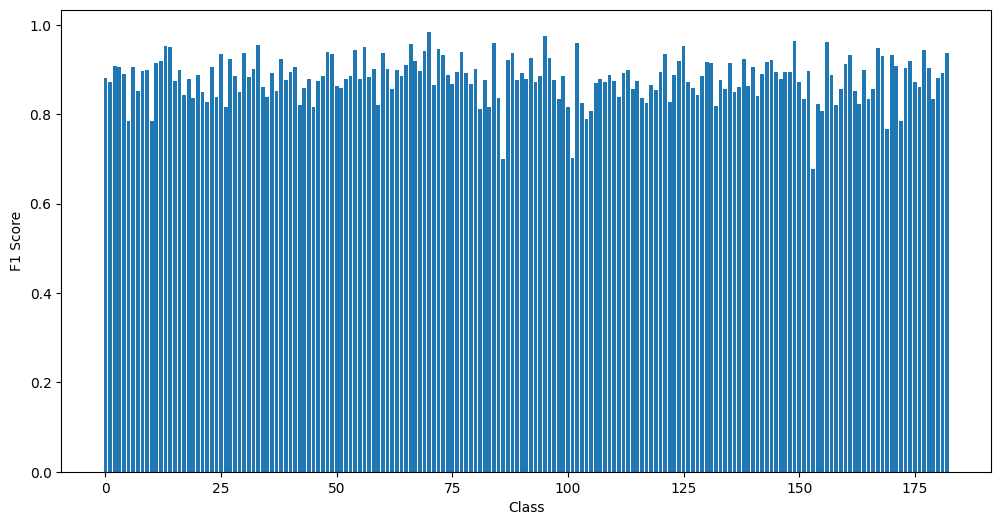

In [19]:
#plot the f1 score for each class
from sklearn.metrics import f1_score
f1_scores = f1_score(results_df['label'], results_df['prediction'], average=None)
f1_scores_df = pd.DataFrame({'class': results_df['label'].unique(), 'f1_score': f1_scores})
plt.figure(figsize=(12, 6))
plt.bar(f1_scores_df['class'], f1_scores_df['f1_score'])
plt.xlabel('Class')
plt.ylabel('F1 Score')

In [34]:
#print the 10 classes with the lowest f1 score 
#print("10 classes with the lowest accuracy:")
#print(accuracy_per_class.nsmallest(30, 'accuracy'))
print("10 classes with the lowest F1-score:")
print(f1_scores_df.nsmallest(30, 'f1_score'))

10 classes with the lowest F1-score:
     class  f1_score
175    153  0.676923
151     86  0.700000
79     101  0.701613
171    169  0.766917
36       5  0.784314
45      10  0.784314
28     172  0.784566
130    104  0.789916
74     155  0.807547
84     105  0.808511
166     81  0.811594
44     100  0.815534
123     45  0.815789
65      26  0.815951
126     83  0.817352
30     132  0.819444
63      42  0.820717
178     59  0.821429
167    158  0.821918
159    163  0.822222
11     154  0.822823
131    117  0.825581
149    103  0.826087
78      22  0.828571
81     122  0.828729
128    165  0.833333
165    151  0.833333
75      98  0.834951
169    179  0.835443
53     116  0.835556


In [24]:
test_df.head()

,filename_index,Habitat,Latitude,Longitude,Substrate,eventDate,taxonID_index,camera_model,camera_maker,DataTime,DateTimeOriginal
10152,fungi_train000000.jpg,NaN,NaN,NaN,NaN,NaN,66.0,iPhone 7 Plus,Apple,2020:10:10 15:06:13,2020:10:10 15:06:13
10153,fungi_train000001.jpg,NaN,NaN,NaN,NaN,NaN,174.0,Canon EOS 500D,Canon,2013:09:10 13:07:49,2013:09:10 13:07:49
10154,fungi_train000002.jpg,NaN,NaN,NaN,NaN,NaN,50.0,Canon PowerShot G16,Canon,2018:09:08 14:56:23,2018:09:08 14:56:23
10155,fungi_train000003.jpg,NaN,NaN,NaN,NaN,NaN,72.0,NIKON D5600,NIKON CORPORATION,2017:10:11 12:49:37,2017:10:11 12:49:37
10156,fungi_train000004.jpg,NaN,NaN,NaN,NaN,NaN,30.0,E-PL1,OLYMPUS IMAGING CORP.,2013:09:14 14:37:41,2013:09:14 14:37:41


In [ ]:
with open(output_file, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    # Write rows into the file
    writer.writerows(data)

In [27]:
f1_scores_df.head()

,class,f1_score
0,66,0.958595
1,174,0.919847
2,50,0.864130
3,72,0.945774
4,30,0.937173


In [52]:
import pandas as pd
import numpy as np

def select_low_f1_samples(test_df, f1_scores_df, n):
    # Define attribute weights
    weights = {"Habitat": 2, "Substrate": 2, "Latitude": 1, "Longitude": 1}
    #attr_order = ["Substrate", "Habitat", "Latitude", "Longitude"]
    attr_order = ["Substrate", "Habitat"]

    # Sort classes by f1_score ascending
    sorted_classes = f1_scores_df.sort_values(by="f1_score")["class"].tolist()

    data = []
    total_value = 0

    for cls in sorted_classes:
        # Get all rows from test_df with this class
        class_rows = test_df[test_df["taxonID_index"] == cls]

        for _, row in class_rows.iterrows():
            missing_attrs = []
            img_name = row["filename_index"]

            # Check each attribute and add if missing
            for attr in attr_order:
                if pd.isna(row[attr]):
                    missing_attrs.append(attr)

            # If there are missing attributes, make sublist
            if missing_attrs:
                for att in missing_attrs:
                    entry = [img_name] + [att]
                    data.append(entry)

                # Add to total_value based on missing attr weights
                total_value += sum(weights[attr] for attr in missing_attrs)

                # Stop when we reach n
                if total_value >= n:
                    return data

    return data

In [53]:
result = select_low_f1_samples(test_df, f1_scores_df, n=27300)
print(result)

[['fungi_train001548.jpg', 'Substrate'], ['fungi_train001548.jpg', 'Habitat'], ['fungi_train001932.jpg', 'Substrate'], ['fungi_train001932.jpg', 'Habitat'], ['fungi_train002063.jpg', 'Substrate'], ['fungi_train002063.jpg', 'Habitat'], ['fungi_train003729.jpg', 'Substrate'], ['fungi_train003729.jpg', 'Habitat'], ['fungi_train005017.jpg', 'Substrate'], ['fungi_train005017.jpg', 'Habitat'], ['fungi_train010043.jpg', 'Substrate'], ['fungi_train010043.jpg', 'Habitat'], ['fungi_train011364.jpg', 'Substrate'], ['fungi_train011364.jpg', 'Habitat'], ['fungi_train015234.jpg', 'Substrate'], ['fungi_train015234.jpg', 'Habitat'], ['fungi_train000711.jpg', 'Substrate'], ['fungi_train000711.jpg', 'Habitat'], ['fungi_train000770.jpg', 'Substrate'], ['fungi_train000770.jpg', 'Habitat'], ['fungi_train001446.jpg', 'Substrate'], ['fungi_train001446.jpg', 'Habitat'], ['fungi_train002347.jpg', 'Substrate'], ['fungi_train002347.jpg', 'Habitat'], ['fungi_train002429.jpg', 'Substrate'], ['fungi_train002429.jpg

In [54]:
output_file = "C:/Users/bmsha/sc2025/shoppinglist.csv"

# Write data to the CSV file
with open(output_file, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    # Write rows into the file
    writer.writerows(result)
print(f"Data has been successfully written to '{output_file}'.")

Data has been successfully written to 'C:/Users/bmsha/sc2025/shoppinglist.csv'.


In [56]:
"""
Fuse camera info into metadata.

Keeps columns:
    ['filename_index', 'Habitat', 'Latitude', 'Longitude', 'Substrate', 'eventDate', 'taxonID_index']

Adds columns (if present in camera file):
    ['camera_model', 'camera_maker', 'DataTime', 'DateTimeOriginal']

Join key preference:
    - 'filename_index' if present in both files
    - otherwise all common columns between the two files

Usage:
    python fuse_metadata.py --meta metadata.csv --camera metadata_with_camera_info.csv --out metadata_fused.csv
"""

import argparse
import pandas as pd

def main(meta_csv, camera_csv, out_csv):
    meta = pd.read_csv(meta_csv)
    camera = pd.read_csv(camera_csv)

    preserve_cols = ['filename_index', 'Habitat', 'Latitude', 'Longitude', 'Substrate', 'eventDate', 'taxonID_index']
    requested_camera_cols = ['camera_model', 'camera_maker', 'DataTime', 'DateTimeOriginal']

    # Determine camera columns actually present
    camera_cols_present = [c for c in requested_camera_cols if c in camera.columns]

    # Determine join key(s)
    if 'filename_index' in meta.columns and 'filename_index' in camera.columns:
        join_keys = ['filename_index']
    else:
        common = [c for c in meta.columns if c in camera.columns]
        join_keys = common if common else None

    keep_cols_present = [c for c in preserve_cols if c in meta.columns]
    meta_subset = meta[keep_cols_present].copy()

    if join_keys:
        merged = meta_subset.merge(
            camera[join_keys + camera_cols_present].drop_duplicates(subset=join_keys),
            on=join_keys,
            how='left'
        )
    else:
        for c in camera_cols_present:
            meta_subset[c] = pd.NA
        merged = meta_subset

    merged.to_csv(out_csv, index=False)


In [57]:
meta_csv = "C:/Users/bmsha/sc2025/metadata_1/metadata.csv"
camera_csv = "C:/Users/bmsha/sc2025/metadata_1/metadata_with_camera_info.csv"
out_csv = "C:/Users/bmsha/sc2025/metadata_1/metadata_fused_2.csv"
main(meta_csv, camera_csv, out_csv)